## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'
# file = 'air_passengers.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
# data_df.head(5)

In [5]:
# data_df.tail(5)

**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()

In [7]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
# train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
# train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [8]:
train_df.shape, test_df.shape

((8213, 2), (547, 2))

In [9]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
# print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
# print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


### Create Folds using CV Splits and Fit

In [10]:
freq = "H"
random_seed = 0
B_values = [5, 10, 20]  # bootstrapped models B, recommended [20-50]
fold_pct = 0.04  # <= 0.04
fold_overlap_pct = 0.  # 0
# METRICS = ['SmoothL1Loss', 'MAE', 'RMSE']
# params = {"seasonality_mode": "multiplicative", "learning_rate": 0.1}

In [11]:
quantile_lo = 0.05
quantile_hi = 0.95
quantile_lo_str = str(quantile_lo*100)
quantile_hi_str = str(quantile_hi*100)
quantiles = [quantile_lo, quantile_hi]

params = {'quantiles': quantiles}

In [12]:
cols = ['y', 'yhat1', 'residual1', f'yhat1 {quantile_lo_str}%', f'yhat1 {quantile_hi_str}%']
forecast_dict = defaultdict(pd.DataFrame)

In [13]:
%%time
for B in B_values:
    folds = NeuralProphet().crossvalidation_split_df(
        train_df,
        freq=freq,
        k=B,
        fold_pct=fold_pct,
        fold_overlap_pct=fold_overlap_pct
    )
    for train_df, cal_df in folds:
        m = NeuralProphet(**params)
        set_random_seed(random_seed)
        metrics = m.fit(train_df, freq=freq, minimal=True)
        forecast = m.predict(cal_df)
        forecast_dict[B] = pd.concat([forecast_dict[B], forecast[cols]], ignore_index=True)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 114


  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.87E-02, min: 1.54E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.49E-02
Epoch[114/114]: 100%|██████████| 114/114 [01:16<00:00,  1.49it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.61E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.61E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[113/113]: 100%|██████████| 113/113 [01:12<00:00,  1.56it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.13E-02, min: 1.86E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.86E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.72E-02
Epoch[112/112]: 100%|██████████| 112/112 [01:12<00:00,  1.54it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/147 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([294, 1, 1])) that is different to the input size (torch.Size([294, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 6.04E-01


  0%|          | 0/147 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 4.55E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.64E-02
Epoch[110/110]: 100%|██████████| 110/110 [01:24<00:00,  1.31it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/147 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([294, 1, 1])) that is different to the input size (torch.Size([294, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.23E-02, min: 5.24E-01


  0%|          | 0/147 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 5.24E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.96E-02
Epoch[109/109]: 100%|██████████| 109/109 [01:20<00:00,  1.35it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.695% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.979% of the data.
INFO - (NP.df_utils.

  0%|          | 0/142 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([284, 1, 1])) that is different to the input size (torch.Size([284, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.55E-02, min: 5.04E-01


  0%|          | 0/142 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.55E-02, min: 4.35E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.76E-02
Epoch[125/125]: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.98% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/142 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([284, 1, 1])) that is different to the input size (torch.Size([284, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.55E-02, min: 1.55E-01


  0%|          | 0/142 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.55E-02, min: 1.80E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.76E-02
Epoch[123/123]: 100%|██████████| 123/123 [01:01<00:00,  1.99it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/143 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([286, 1, 1])) that is different to the input size (torch.Size([286, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 1.41E-01


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 6.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.00E-02
Epoch[121/121]: 100%|██████████| 121/121 [01:01<00:00,  1.98it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/144 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([288, 1, 1])) that is different to the input size (torch.Size([288, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.17E-02, min: 1.70E-01


  0%|          | 0/144 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.17E-02, min: 5.42E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.25E-02
Epoch[119/119]: 100%|██████████| 119/119 [01:00<00:00,  1.96it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/144 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([288, 1, 1])) that is different to the input size (torch.Size([288, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.17E-02, min: 1.70E-01


  0%|          | 0/144 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 4.06E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.90E-02
Epoch[117/117]: 100%|██████████| 117/117 [01:05<00:00,  1.78it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.54E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.81E-02
Epoch[116/116]: 100%|██████████| 116/116 [01:10<00:00,  1.64it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.33E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 4.22E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.81E-02
Epoch[114/114]: 100%|██████████| 114/114 [01:06<00:00,  1.71it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[113/113]: 100%|██████████| 113/113 [01:14<00:00,  1.52it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[112/112]: 100%|██████████| 112/112 [01:18<00:00,  1.44it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/147 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([294, 1, 1])) that is different to the input size (torch.Size([294, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 8.02E-01


  0%|          | 0/147 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.41E-02, min: 1.46E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.64E-02
Epoch[110/110]: 100%|██████████| 110/110 [01:21<00:00,  1.36it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.683% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.935% of the data.
INFO - (NP.df_utils.

  0%|          | 0/130 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([260, 1, 1])) that is different to the input size (torch.Size([260, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/130 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.18E-02, min: 1.62E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.25E-02
Epoch[170/170]: 100%|██████████| 170/170 [00:25<00:00,  6.55it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.945% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/132 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([264, 1, 1])) that is different to the input size (torch.Size([264, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.90E-02, min: 1.52E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.04E-02
Epoch[162/162]: 100%|██████████| 162/162 [00:28<00:00,  5.65it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.953% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/133 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([266, 1, 1])) that is different to the input size (torch.Size([266, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/133 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.24E-02, min: 1.60E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.31E-02
Epoch[155/155]: 100%|██████████| 155/155 [00:31<00:00,  4.98it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.959% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/135 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([270, 1, 1])) that is different to the input size (torch.Size([270, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/135 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.97E-02, min: 1.76E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.09E-02
Epoch[149/149]: 100%|██████████| 149/149 [00:36<00:00,  4.09it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.963% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/136 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([272, 1, 1])) that is different to the input size (torch.Size([272, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/136 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.31E-02, min: 1.58E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.99E-02
Epoch[144/144]: 100%|██████████| 144/144 [00:38<00:00,  3.75it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/137 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([274, 1, 1])) that is different to the input size (torch.Size([274, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.72E-02, min: 1.66E-01


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.72E-02, min: 1.66E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.89E-02
Epoch[140/140]: 100%|██████████| 140/140 [00:39<00:00,  3.56it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.97% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.


  0%|          | 0/138 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([276, 1, 1])) that is different to the input size (torch.Size([276, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/138 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.04E-02, min: 1.74E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.15E-02
Epoch[137/137]: 100%|██████████| 137/137 [00:43<00:00,  3.14it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.973% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/139 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([278, 1, 1])) that is different to the input size (torch.Size([278, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/139 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.48E-02, min: 1.57E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.70E-02
Epoch[134/134]: 100%|██████████| 134/134 [00:46<00:00,  2.86it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.975% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([280, 1, 1])) that is different to the input size (torch.Size([280, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.79E-02, min: 1.64E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.95E-02
Epoch[131/131]: 100%|██████████| 131/131 [00:50<00:00,  2.61it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.976% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/140 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([280, 1, 1])) that is different to the input size (torch.Size([280, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/

  0%|          | 0/140 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.79E-02, min: 4.67E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.95E-02
Epoch[128/128]: 100%|██████████| 128/128 [00:54<00:00,  2.35it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.978% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/141 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([282, 1, 1])) that is different to the input size (torch.Size([282, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.27E-02, min: 1.48E-01


  0%|          | 0/141 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.11E-02, min: 1.72E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.85E-02
Epoch[126/126]: 100%|██████████| 126/126 [00:55<00:00,  2.28it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.979% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/142 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([284, 1, 1])) that is different to the input size (torch.Size([284, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.55E-02, min: 1.55E-01


  0%|          | 0/142 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.43E-02, min: 1.55E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.10E-02
Epoch[124/124]: 100%|██████████| 124/124 [00:56<00:00,  2.21it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.981% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/143 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([286, 1, 1])) that is different to the input size (torch.Size([286, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.06E-02, min: 5.23E-01


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 1.63E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.67E-02
Epoch[122/122]: 100%|██████████| 122/122 [00:58<00:00,  2.07it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.982% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/143 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([286, 1, 1])) that is different to the input size (torch.Size([286, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 1.63E-01


  0%|          | 0/143 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.86E-02, min: 5.23E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.00E-02
Epoch[120/120]: 100%|██████████| 120/120 [01:05<00:00,  1.84it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/144 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([288, 1, 1])) that is different to the input size (torch.Size([288, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 1.47E-01


  0%|          | 0/144 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.17E-02, min: 1.47E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.90E-02
Epoch[118/118]: 100%|██████████| 118/118 [01:09<00:00,  1.70it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.983% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/144 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([288, 1, 1])) that is different to the input size (torch.Size([288, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.17E-02, min: 5.42E-01


  0%|          | 0/144 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.34E-02, min: 4.69E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.90E-02
Epoch[117/117]: 100%|██████████| 117/117 [01:17<00:00,  1.50it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.984% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 6.49E-02, min: 1.78E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 1.54E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.15E-02
Epoch[115/115]: 100%|██████████| 115/115 [01:19<00:00,  1.45it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/145 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([290, 1, 1])) that is different to the input size (torch.Size([290, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 4.87E-01


  0%|          | 0/145 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.62E-02, min: 4.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 6.81E-02
Epoch[114/114]: 100%|██████████| 114/114 [01:11<00:00,  1.60it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.61E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.83E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[113/113]: 100%|██████████| 113/113 [01:17<00:00,  1.45it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.986% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.

  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/studio-lab-user/.conda/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 2.85E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[111/111]: 100%|██████████| 111/111 [01:18<00:00,  1.42it/s]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.669% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


CPU times: user 33min 19s, sys: 4.05 s, total: 33min 23s
Wall time: 37min


In [14]:
def plot_nonconformity_scores(scores, q, method):
    plt.plot(scores, label="score")
    plt.axhline(y=q, color="r", linestyle="-", label=f"q1={round(q, 2)}")
    plt.xlabel("Sorted Index")
    plt.ylabel("Nonconformity Score")
    plt.title(f"{method} Nonconformity Score with q")
    plt.legend()
    plt.show();

In [15]:
alpha = 0.1
qhat_df = pd.DataFrame(index=B_values)

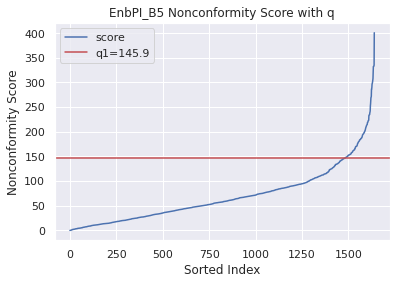

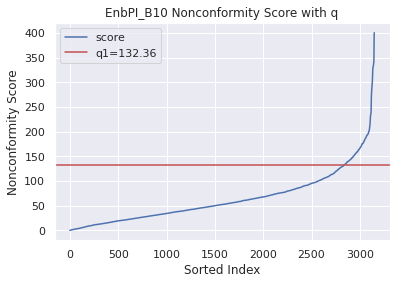

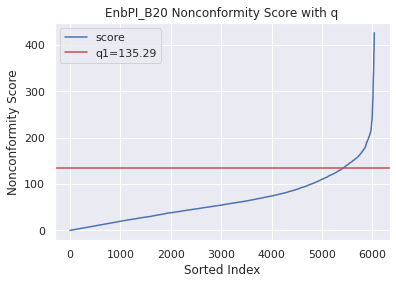

In [16]:
enbpi_qhats = []
for B in B_values:
    enbpi_noncon_scores = np.abs(forecast_dict[B]['residual1'].values)
    enbpi_noncon_scores = enbpi_noncon_scores[~pd.isnull(enbpi_noncon_scores)]  # remove NaN values
    enbpi_noncon_scores.sort()
    # print(enbpi_noncon_scores.shape)

    # get the q-hat index and value
    enbpi_qhat_idx = int(len(enbpi_noncon_scores)*alpha)
    enbpi_qhat = enbpi_noncon_scores[-enbpi_qhat_idx]
    method = f'EnbPI_B{B}'
    plot_nonconformity_scores(enbpi_noncon_scores, enbpi_qhat, method)
    enbpi_qhats.append(enbpi_qhat)

qhat_df['enbpi'] = enbpi_qhats

(1640,)


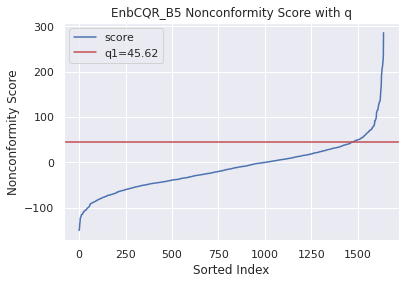

(3150,)


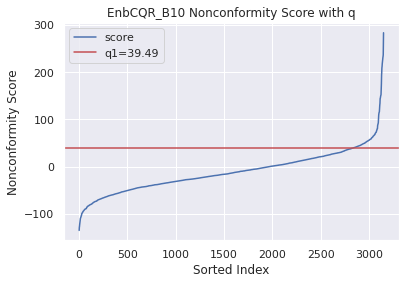

(6040,)


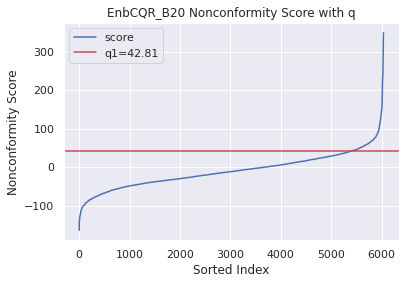

In [17]:
enbcqr_scoring_func = (
    lambda row: [None, None]
    if row[f"yhat1 {quantile_lo_str}%"] is None or row[f"yhat1 {quantile_hi_str}%"] is None
    else [
        max(row[f"yhat1 {quantile_lo_str}%"] - row["y"], row["y"] - row[f"yhat1 {quantile_hi_str}%"]),
        0 if row[f"yhat1 {quantile_lo_str}%"] - row["y"] > row["y"] - row[f"yhat1 {quantile_hi_str}%"] else 1,
    ]
)

enbcqr_qhats = []
for B in B_values:
    enbcqr_scores_df = forecast_dict[B].apply(enbcqr_scoring_func, axis=1, result_type="expand")
    enbcqr_scores_df.columns = ["scores", "arg"]
    enbcqr_noncon_scores = enbcqr_scores_df["scores"].values
    enbcqr_noncon_scores = enbcqr_noncon_scores[~pd.isnull(enbcqr_noncon_scores)]  # remove NaN values
    enbcqr_noncon_scores.sort()
    print(enbcqr_noncon_scores.shape)

    # get the q-hat index and value
    enbcqr_qhat_idx = int(len(enbcqr_noncon_scores)*alpha)
    enbcqr_qhat = enbcqr_noncon_scores[-enbcqr_qhat_idx]
    method = f'EnbCQR_B{B}'
    plot_nonconformity_scores(enbcqr_noncon_scores, enbcqr_qhat, method)
    enbcqr_qhats.append(enbcqr_qhat)

qhat_df['enbcqr'] = enbcqr_qhats

Get forecasts and *EnbPI* and *EnbCQR* conformal prediction interval of OOS test_df

In [18]:
cutoff = 7*24 # 0
x_size = 12
y_size = 6
figsize = (x_size, y_size)
plotting_backend = 'default'

In [19]:
enbpi_forecast_dict = defaultdict(pd.DataFrame)
enbcqr_forecast_dict = defaultdict(pd.DataFrame)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

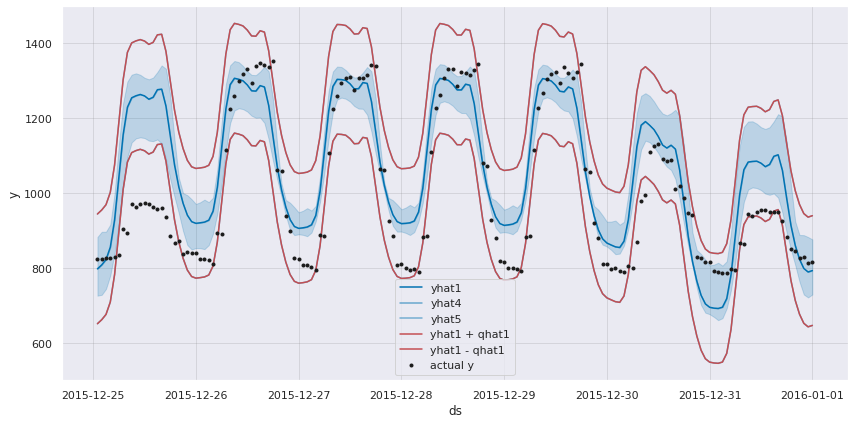

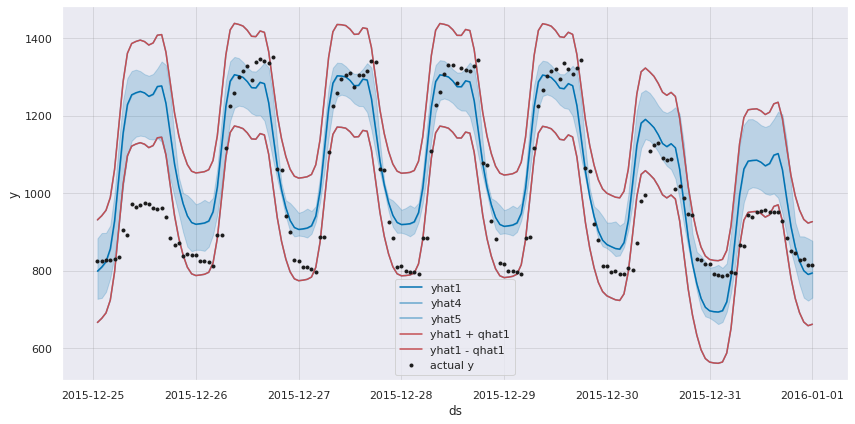

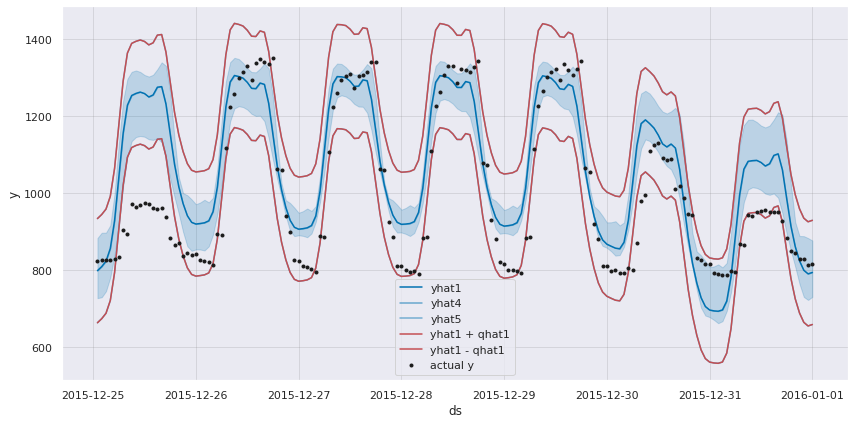

In [20]:
method = 'enbpi'
for B in B_values:
    m.q_hats = [qhat_df.loc[B, method]]
    m.conformal_method = 'naive'
    m.quantile_lo = None
    m.quantile_hi = None
    enbpi_forecast = m.predict(test_df)
    # enbpi_forecast.head()
    enbpi_forecast_dict[B] = enbpi_forecast
    fig = m.highlight_nth_step_ahead_of_each_forecast(1) \
           .plot(enbpi_forecast[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)  # [-cutoff:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID 

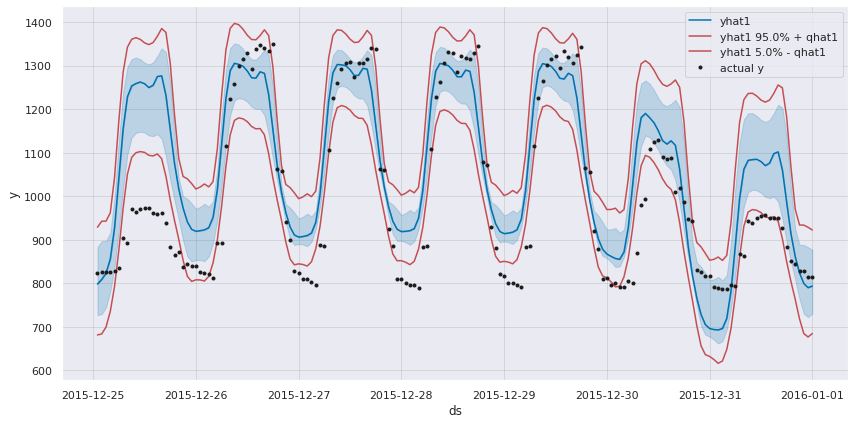

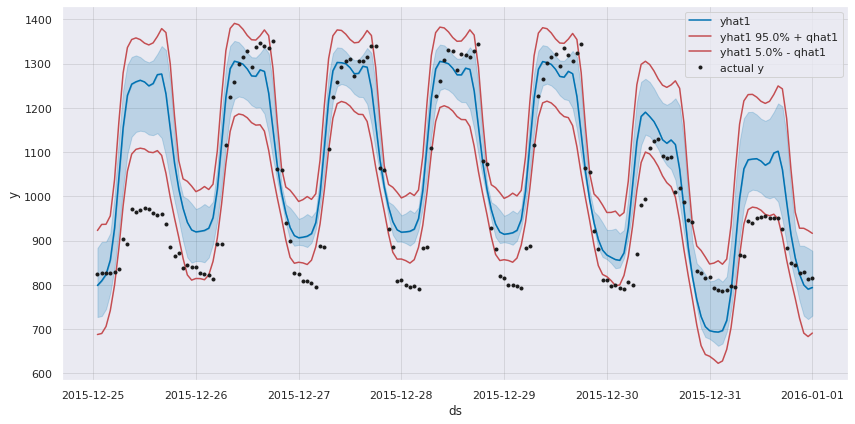

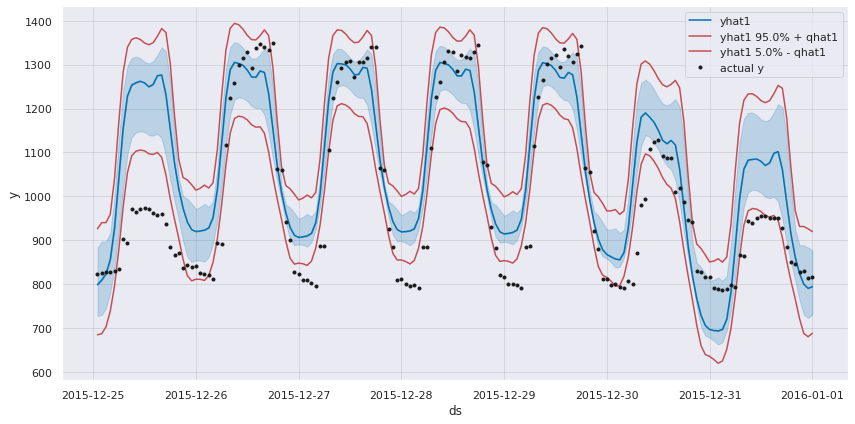

In [21]:
method = 'enbcqr'
for B in B_values:
    m.q_hats = [qhat_df.loc[B, method]]
    m.conformal_method = 'cqr'
    m.quantile_lo = quantile_lo_str
    m.quantile_hi = quantile_hi_str
    enbcqr_forecast = m.predict(test_df)
    # enbcqr_forecast.head()
    enbcqr_forecast_dict[B] = enbcqr_forecast
    fig = m.highlight_nth_step_ahead_of_each_forecast(1) \
           .plot(enbcqr_forecast[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)  # [-cutoff:]

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [22]:
# B_values = [5, 10, 20]
# B_values_str = [f'B_{B}' for B in B_values]
conformal_methods = ['enbpi_tscv', 'enbcqr_tscv']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([B_values, conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [23]:
eval_df['model'] = ['m1']

Enter in the **interval_width** (*efficiency* metric)

In [24]:
# Calculate EnbCQR interval width function
def calc_enbcqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df['yhat1'].mean() - fcast_df[f'yhat1 {qr_lo}%'].mean()
    qr_hi_mean = fcast_df[f'yhat1 {qr_hi}%'].mean() - fcast_df['yhat1'].mean()
    return qr_lo_mean + qr_hi_mean + qhat*2

In [25]:
for B in B_values:
    # enbpi interval width
    enbpi_iw = [qhat_df.loc[B, 'enbpi']*2]
    eval_df[B, 'enbpi_tscv', 'interval_width'] = enbpi_iw

    # EnbCQR interval width
    enbcqr_iw = calc_enbcqr_iw(enbcqr_forecast, quantile_lo_str, quantile_hi_str, qhat_df.loc[B, 'enbcqr'])
    # cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
    # cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
    # cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
    # cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)
    enbcqr_iw = [enbcqr_iw]
    # cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
    eval_df[B, 'enbcqr_tscv', 'interval_width'] = enbcqr_iw

Enter in the **miscoverage rate** (*validity* metric)

In [28]:
# Calculate EnbPI miscoverage rate function
def calc_enbpi_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

# Calculate EnbCQR and EnbCQR Advanced miscoverage rate function
def calc_enbcqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(lambda row: bool(row[f'yhat1 {qr_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {qr_hi}% + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [29]:
for B in B_values:
    # enbpi miscoverage rate
    enbpi_mr = calc_enbpi_mr(enbpi_forecast_dict[B])
    # enbpi_mr1 = calc_enbpi_mr(enbpi_forecast1)
    # enbpi_mr2 = calc_enbpi_mr(enbpi_forecast2)
    # enbpi_mr3 = calc_enbpi_mr(enbpi_forecast3)
    # enbpi_mr4 = calc_enbpi_mr(enbpi_forecast4)
    enbpi_mr = [enbpi_mr]
    # enbpi_mr = [enbpi_mr1, enbpi_mr2, enbpi_mr3, enbpi_mr4]]
    eval_df[B, 'enbpi_tscv', 'miscoverage_rate'] = enbpi_mr

    # CQR miscoverage rate
    enbcqr_mr = calc_enbcqr_mr(enbcqr_forecast_dict[B], quantile_lo_str, quantile_hi_str)
    # cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
    # cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
    # cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
    # cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)
    enbcqr_mr = [enbcqr_mr]
    # cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
    eval_df[B, 'enbcqr_tscv', 'miscoverage_rate'] = enbcqr_mr

Show evaluation dataframe

In [31]:
eval_df

model              5                                                   \
            enbpi_tscv                     enbcqr_tscv                    
        interval_width miscoverage_rate interval_width miscoverage_rate   
0    m1     291.807266         0.124314     218.689991         0.290676   

              10                                                   \
      enbpi_tscv                     enbcqr_tscv                    
  interval_width miscoverage_rate interval_width miscoverage_rate   
0     264.722173         0.157221     206.444156         0.325411   

              20                                                   
      enbpi_tscv                     enbcqr_tscv                   
  interval_width miscoverage_rate interval_width miscoverage_rate  
0     270.573205         0.146252     213.083046          0.30713

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining slightly better *miscoverage rate* (for the advanced AR models m4 and m4). The complex m4 model performs the best for *interval_width* while the simple m1 performs the best for actual *miscoverage rate*, hovering around *alpha*. However, that is because it has also by far the highest *interval_width*. m3 and m4 models have actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.